# Reproduce  H. Huang , et. al , Faraday Discuss., 2018, 208, 555 – 573 

This notebook demonstrates using Larch to reproduce the results of the paper using the corresponding published dataset using the raw data. 


Huang, Haoliang, Nassr, Abu Bakr Ahmed Amine, Celorrio, Verónica, Taylor, S. F. Rebecca, Puthiyapura, Vinod Kumar, Hardacre, Christopher, Brett, Dan J. L., Russell, Andrea E. (2018) **Effects of heat treatment atmosphere on the structure and activity of Pt3Sn nanoparticle electrocatalysts: a characterisation case study.** Faraday Discussions. V. 208. pp. 555-573. DOI: [10.1039/c7fd00221a](https://doi.org/10.1039/c7fd00221a).

The data used for reproducing the results was published in the Southampton Instituional Repository [10.5258/SOTON/D0408](https://eprints.soton.ac.uk/421798/), with the name Xray_data.zip - Dataset.


For more details about Larch, see [Larch Website](https://xraypy.github.io/xraylarch/xafs/)

## Reproduce Figure 4 XANES and LCF
The first set of XAS results in the paper are in [Figure 4](https://pubs.rsc.org/image/article/2018/fd/c7fd00221a/c7fd00221a-f4_hi-res.gif)

To reproduce this image we need to:
- A: Identify the XANES data used (SnO2, Air, Ar, H2 and Sn foil)
  - Plot normalised flattened mE of the spectra on the range 29190 – 29450 
  - Plot first derivate of the spectra on the range 29190 – 29215
- B: Take Sn foil and SnO2 and do LCF of the peaks against H2, Ar, and Air
- C: Take Sn K-Edge of H2/H2 and SnO2 and do LCF of the peaks against H2, Ar, and Air

|Key|Content|
|:--|:--|
|OC|parent|
|OCA| Ar treated|
|OCH| H2 treated|
|OCO|air-treated|

In [33]:
# Library with the functions that rplicate those provided by athena
# normalisation, merging, re-binning, LCF
# and visualisation (plotting)
import lib.manage_athena as athenamgr  

# File handling
from pathlib import Path

#plotting library
%matplotlib inline
import matplotlib.pyplot as plt


## Input parameters (variables)
The variables in the next cell are the processing values that indicate where to get the data from, the pattern of the files to process and the number of files to process. These can be changed to process different datasets.

### Column and group names.

Knowing the elements of the input data set it is possible to start manipulating and visualising the XAFS data. 

In this case energy and $\mu$ are provided, but the names of the columns do not match the names used by Larch provinding the custom column names. 

We rename the columns. The name of the groups is the same as the name of the file. To make things easier we can also adjust the file name.


In [42]:
# variables that can be changed to process different datasets
data_path = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn K-edge/ascii"

data_mappings={"Air":  "*_PtSn_OCO_H*",
              "Ar":  "*_PtSn_OCA_H*",
              "H2":  "*_PtSn_OCH_H*",}

f_prefix = "PtSn_KEdge"
column_labels = "energy time I0 It Iref  mu lnItIref"

show_graph = True # False to prevent showing graphs

## Get fata and merge results for each sample in list
The below reads the raw readings for eache of the samples in data mappings and merges them to create the signals to be processed.



In [43]:
# start processing createa an output dir and sets the logger
source_path, out_path = athenamgr.files_setup(f_prefix, data_path)
print(source_path, out_path)


merged_results={}
# read all samples, merge and then normalise
for a_sample in data_mappings:
    files_list = athenamgr.get_files_list(source_path, data_mappings[a_sample])

    # read the files for each sample

    sample_list = []

    for i_count, a_file  in enumerate(files_list):
        file_name = a_file.name
        f_suffix = str(i_count).zfill(4) 
        p_name = f_prefix+f_suffix
        p_path = Path(out_path , p_name + ".prj")
        a_group = athenamgr.read_text(a_file, column_labels)
        sample_list.append(a_group)
        
    # merge readings for sample
    merged_xas = athenamgr.merge_readings(sample_list)

    # rename group (same as the file name)
    merged_xas.filename = a_sample
    merged_results[a_sample] = merged_xas
    # calculate pre-edge and post edge and add them to group
    # using defaults
    xas_data = athenamgr.fit_pre_post_edge(merged_xas)

# results in the paper are recalibrated to 29200
recalibrate_e0_to = 29204

for a_sample in merged_results:
    merged_results[a_sample] = athenamgr.recalibrate_energy(merged_results[a_sample], recalibrate_e0_to)


C:\harwell\PSDI_test\wf_data\pub_037\XAFS_prj\Sn K-edge\ascii PtSn_KEdge


## Get standards
The code below reads the Sn Foil and SnO2 project and retrieves the foil data used to copare to the readings


In [44]:
# get the Sn foil from project:
sn_foil = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/Sn foil.prj"
# read the input file 
sn_foil_prj = athenamgr.read_project(sn_foil)

sn_foil_group = athenamgr.get_group(sn_foil_prj, 'merge')
sn_foil_group.filename = "Sn Foil"
sn_foil_group = athenamgr.recalibrate_energy(sn_foil_group, recalibrate_e0_to)
merged_results["Sn Foil"] = sn_foil_group

# get the Sn O2 standard from project:
sno2 = "C:/harwell/PSDI_test/wf_data/pub_037/XAFS_prj/SnO2 0.9 2.6-13.5 gbkg.prj"
# read the input file 
sno2_prj = athenamgr.read_project(sno2)

sno2_group = athenamgr.get_group(sno2_prj, 'SnO2_0_9_2_6_13_5_0_8_1_0_with_theory')
sno2_group.filename = "SnO2 0.9"
sno2_group = athenamgr.recalibrate_energy(sno2_group, recalibrate_e0_to)
merged_results["SnO2 0.9"] = sno2_group

## Plot the mu signals for the reading and the Sn Foil

These are the plots shown on Fig. 4 A

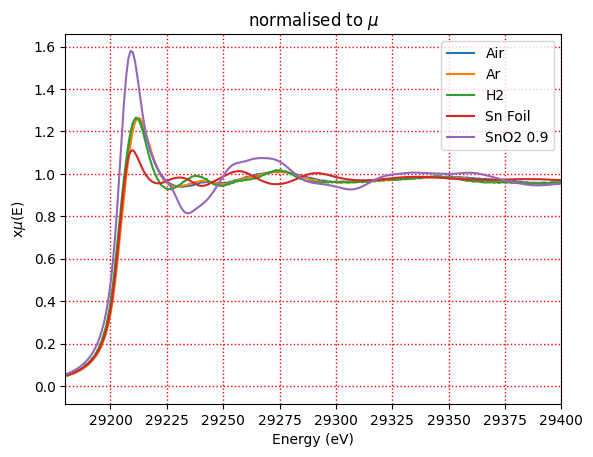

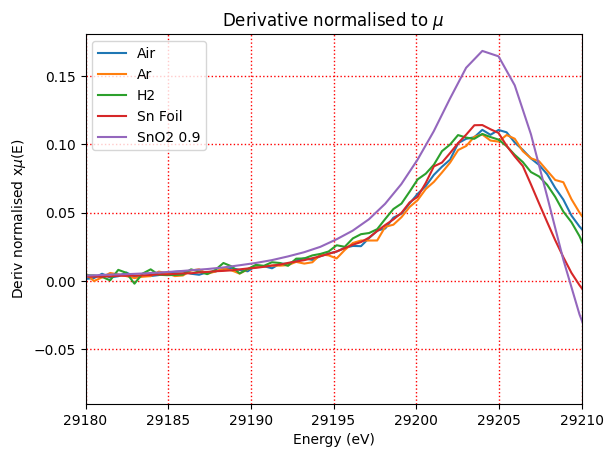

In [45]:
for a_sample in merged_results:
    plt = athenamgr.plot_normalised(merged_results[a_sample])
    
plt.xlim([29180, 29400])
plt.show()

for a_sample in merged_results:
    plt = athenamgr.plot_derivative(merged_results[a_sample])
    
plt.xlim([29180, 29210])
plt.show()

## LCF

These are the plots shown on Fig. 4 A

In [46]:
from larch import math

In [51]:
lcf_components = [ merged_results["SnO2 0.9"],merged_results["Sn Foil"]] # List of groups to use as components 
r = math.lincombo_fit(merged_results["Air"], lcf_components)

In [52]:
r.result

In [13]:
math.lincombo_fit

<function larch.math.lincombo_fitting.lincombo_fit(group, components, weights=None, minvals=None, maxvals=None, arrayname='norm', xmin=-inf, xmax=inf, sum_to_one=True, vary_e0=False, max_ncomps=None)>

In [19]:
r.ydata

array([0.00807403, 0.00602404, 0.00471713, ..., 0.80434068, 0.80276172,
       0.80432413])

In [55]:
r.weights

OrderedDict([('SnO2 0.9', 0.9103271475246275),
             ('Sn Foil', 0.08967285247537249)])